In [1]:
## You need to change the project ID to match your GCP
PROJECT_ID = "halogen-rarity-312520"

In [2]:
import os
from google.colab import auth

#sets dateset
DATASET_PROJECT_ID = 'amsterdamumcdb-data'
DATASET_ID = 'ams102'
LOCATION = 'eu'

#all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

#sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)

#sets client options job configuration
client_options = {}
client_options['location'] = LOCATION

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [5]:
pd.set_option('display.max_rows', 100)

In [6]:
config_gbq = {'query': 
          {'defaultDataset': {
              "datasetId": DATASET_ID, 
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

In [7]:
diagnoses_sql = '''
WITH diagnoses AS (
    SELECT admissionid,
        item, 
        value as diagnosis,
        CASE
            WHEN itemid IN (
                --SURGICAL
                13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
                16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
                13117, --D_Thoraxchirurgie_Cardio anders
                16672, --DMC_Thoraxchirurgie_Cardio anders
                13118, --D_Thoraxchirurgie_Aorta chirurgie
                16670, --DMC_Thoraxchirurgie_Aorta chirurgie
                13119, --D_Thoraxchirurgie_Pulmonale chirurgie
                16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie

                --Not surgical: 13141, --D_Algemene chirurgie_Algemeen   
                --Not surgical: 16642, --DMC_Algemene chirurgie_Algemeen
                13121, --D_Algemene chirurgie_Buikchirurgie
                16643, --DMC_Algemene chirurgie_Buikchirurgie
                13123, --D_Algemene chirurgie_Endocrinologische chirurgie
                16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
                13145, --D_Algemene chirurgie_KNO/Overige
                16645, --DMC_Algemene chirurgie_KNO/Overige
                13125, --D_Algemene chirurgie_Orthopedische chirurgie
                16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
                13122, --D_Algemene chirurgie_Transplantatie chirurgie
                16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
                13124, --D_Algemene chirurgie_Trauma
                16648, --DMC_Algemene chirurgie_Trauma
                13126, --D_Algemene chirurgie_Urogenitaal
                16649, --DMC_Algemene chirurgie_Urogenitaal
                13120, --D_Algemene chirurgie_Vaatchirurgie
                16650, --DMC_Algemene chirurgie_Vaatchirurgie

                13128, --D_Neurochirurgie _Vasculair chirurgisch
                16661, --DMC_Neurochirurgie _Vasculair chirurgisch
                13129, --D_Neurochirurgie _Tumor chirurgie
                16660, --DMC_Neurochirurgie _Tumor chirurgie
                13130, --D_Neurochirurgie_Overige
                16662, --DMC_Neurochirurgie_Overige

                18596, --Apache II Operatief  Gastr-intenstinaal
                18597, --Apache II Operatief Cardiovasculair
                18598, --Apache II Operatief Hematologisch
                18599, --Apache II Operatief Metabolisme
                18600, --Apache II Operatief Neurologisch
                18601, --Apache II Operatief Renaal
                18602, --Apache II Operatief Respiratoir

                17008, --APACHEIV Post-operative cardiovascular
                17009, --APACHEIV Post-operative gastro-intestinal
                17010, --APACHEIV Post-operative genitourinary
                17011, --APACHEIV Post-operative hematology
                17012, --APACHEIV Post-operative metabolic
                17013, --APACHEIV Post-operative musculoskeletal /skin
                17014, --APACHEIV Post-operative neurologic
                17015, --APACHEIV Post-operative respiratory
                17016, --APACHEIV Post-operative transplant
                17017 --APACHEIV Post-operative trauma

            ) THEN 1
            WHEN itemid = 18669 AND valueid BETWEEN 1 AND 26 THEN 1 --NICE APACHEII diagnosen
            WHEN itemid = 18671 AND valueid BETWEEN 222 AND 452 THEN 1 --NICE APACHEIV diagnosen
            ELSE 0
        END AS surgical,
        valueid as diagnosis_id,
        CASE 
                WHEN itemid = 18671 THEN 'NICE APACHE IV'
                WHEN itemid = 18669 THEN 'NICE APACHE II'
                WHEN itemid BETWEEN 16998 AND 17017 THEN 'APACHE IV'
                WHEN itemid BETWEEN 18589 AND 18602 THEN 'APACHE II'
                WHEN itemid BETWEEN 13116 AND 13145 THEN 'Legacy ICU'
                WHEN itemid BETWEEN 16642 AND 16673 THEN 'Legacy MCU'
        END AS diagnosis_type,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY 
            CASE --prefer NICE > APACHE IV > II > D
                WHEN itemid = 18671 THEN 6 --NICE APACHEIV diagnosen
                WHEN itemid = 18669 THEN 5 --NICE APACHEII diagnosen                
                WHEN itemid BETWEEN 16998 AND 17017 THEN 4 --APACHE IV diagnosis        
                WHEN itemid BETWEEN 18589 AND 18602 THEN 3 --APACHE II diagnosis
                WHEN itemid BETWEEN 13116 AND 13145 THEN 2 --D diagnosis ICU
                WHEN itemid BETWEEN 16642 AND 16673 THEN 1 --DMC diagnosis Medium Care
            END DESC,
            measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie
        
        13141, --D_Algemene chirurgie_Algemeen   
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie

        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige
        
        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir
        
        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017, --APACHEIV Post-operative trauma

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige

        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige 
        13127, --D_KNO/Overige
        
        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir
        
        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007, --APACHEIV Non-operative trauma
        
        --NICE: surgical/medical combined in same parameter
        18669, --NICE APACHEII diagnosen
        18671 --NICE APACHEIV diagnosen
    )
), sepsis AS (
    SELECT
        admissionid,
        CASE valueid
            WHEN 1 THEN 1 --'Ja'
            WHEN 2 THEN 0 --'Nee'
        END as sepsis_at_admission,
        ROW_NUMBER() OVER(
            PARTITION BY 
                admissionid
            ORDER BY 
                measuredat DESC) AS rownum
    FROM listitems
    WHERE 
        itemid = 15808
), sepsis_antibiotics AS ( --non prophylactic antibiotics
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_antibiotics_given
    FROM drugitems
    WHERE 
        itemid IN (
            6834, --Amikacine (Amukin)
            6847, --Amoxicilline (Clamoxyl/Flemoxin)
            6871, --Benzylpenicilline (Penicilline)
            6917, --Ceftazidim (Fortum)
            --6919, --Cefotaxim (Claforan) -> prophylaxis
            6948, --Ciprofloxacine (Ciproxin)
            6953, --Rifampicine (Rifadin)
            6958, --Clindamycine (Dalacin)
            7044, --Tobramycine (Obracin)
            --7064, --Vancomycine -> prophylaxis for valve surgery
            7123, --Imipenem (Tienam)
            7185, --Doxycycline (Vibramycine)
            --7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            --7208, --Erythromycine (Erythrocine) -> often used for gastroparesis
            7227, --Flucloxacilline (Stafoxil/Floxapen)
            7231, --Fluconazol (Diflucan)
            7232, --Ganciclovir (Cymevene)
            7233, --Flucytosine (Ancotil)
            7235, --Gentamicine (Garamycin)
            7243, --Foscarnet trinatrium (Foscavir)
            7450, --Amfotericine B (Fungizone)
            --7504, --X nader te bepalen --non-stock medication
            8127, --Meropenem (Meronem)
            8229, --Myambutol (ethambutol)
            8374, --Kinine dihydrocloride
            --8375, --Immunoglobuline (Nanogam) -> not anbiotic
            --8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            8547, --Voriconazol(VFEND)
            --9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9030, --Aztreonam (Azactam)
            9047, --Chlooramfenicol
            --9075, --Fusidinezuur (Fucidin) -> prophylaxis
            9128, --Piperacilline (Pipcil)
            9133, --Ceftriaxon (Rocephin)
            --9151, --Cefuroxim (Zinacef) -> often used for GI/transplant surgical prophylaxis
            --9152, --Cefazoline (Kefzol) -> prophylaxis for cardiac surgery
            9458, --Caspofungine
            9542, --Itraconazol (Trisporal)
            --9602, --Tetanusimmunoglobuline -> prophylaxis/not antibiotic
            12398, --Levofloxacine (Tavanic)
            12772, --Amfotericine B lipidencomplex  (Abelcet)
            15739, --Ecalta (Anidulafungine)
            16367, --Research Anidulafungin/placebo
            16368, --Research Caspofungin/placebo
            18675, --Amfotericine B in liposomen (Ambisome )
            19137, --Linezolid (Zyvoxid)
            19764, --Tigecycline (Tygacil)
            19773, --Daptomycine (Cubicin)
            20175 --Colistine
        )
        AND start < 6*60*60*1000 --within 6 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid
), other_antibiotics AS ( --'prophylactic' antibiotics that may be used for sepsis
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS other_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS other_antibiotics_given
    FROM drugitems
    WHERE 
        itemid IN (
            7064, --Vancomycine -> prophylaxis for valve surgery
            7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9151, --Cefuroxim (Zinacef) -> often used for GI surgical prophylaxis
            9152 --Cefazoline (Kefzol) -> prophylaxis
        )
        AND start < 24*60*60*1000 --within 24 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid    
), cultures AS (
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_cultures_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_cultures_drawn
    FROM procedureorderitems
    WHERE 
        itemid IN (
        --8097, --Sputumkweek afnemen -> often used routinely
        --8418, --Urinekweek afnemen
        --8588, --MRSA kweken afnemen 
        9189, --Bloedkweken afnemen
        9190, --Cathetertipkweek afnemen
        --9191, --Drainvochtkweek afnemen
        --9192, --Faeceskweek afnemen -> Clostridium
        --9193, --X-Kweek nader te bepalen
        --9194, --Liquorkweek afnemen
        --9195, --Neuskweek afnemen
        --9197, --Perineumkweek afnemen -> often used routinely
        -9198, --Rectumkweek afnemen -> often used routinely
        9200, --Wondkweek afnemen
        9202, --Ascitesvochtkweek afnemen
        --9203, --Keelkweek afnemen -> often used routinely
        --9204, --SDD-kweken afnemen -> often used routinely
        9205 --Legionella sneltest (urine)
        --1302, --SDD Inventarisatiekweken afnemen -> often used routinely
        --19663, --Research Neuskweek COUrSe
        --19664, --Research Sputumkweek COUrSe
        )
        AND registeredat < 6*60*60*1000 --within 6 hours
    GROUP BY admissionid
)
SELECT 
    admissions.* 
    , diagnosis_type
    , diagnosis, diagnosis_id
    , surgical
    , sepsis_at_admission
    , sepsis_antibiotics_bool
    , sepsis_antibiotics_given
    , other_antibiotics_bool
    , other_antibiotics_given
    , sepsis_cultures_bool
    , sepsis_cultures_drawn
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
LEFT JOIN sepsis on admissions.admissionid = sepsis.admissionid
LEFT JOIN sepsis_antibiotics on admissions.admissionid = sepsis_antibiotics.admissionid
LEFT JOIN other_antibiotics on admissions.admissionid = other_antibiotics.admissionid
LEFT JOIN cultures on admissions.admissionid = cultures.admissionid
WHERE --only last updated record
    (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL) AND 
    (sepsis.rownum = 1 OR sepsis.rownum IS NULL) 
;
'''

In [8]:
af = pd.read_gbq(
    '''
    SELECT
      admissionid
      ,itemid
      --,item
      ,valueid
      --,value
      ,measuredat
      --,registeredat
      --,registeredby
      --,updatedat
      --,updatedby
      --,islabresult
    FROM listitems
    WHERE 
      itemid = 6671	--Hartritme
      AND valueid = 13	--Atr fib
    '''
    , configuration=config_gbq)

In [9]:
# af_inclusion_tf = (af['measuredat'] > 0.5 * 60 * 60 * 1000) & (af['measuredat'] < 5 * 24 * 60 * 60 * 1000)
# af_exclusion_tf = af['measuredat'] < 0

af_inclusion_tf = af['measuredat'] < 5 * 24 * 60 * 60 * 1000
af_exclusion_tf = af['measuredat'] < 0.5 * 60 * 60 * 1000

## Note we will also want to remove all patients who have an AF event before 30 mins if we decide this isn't NOAF
include_admissionid = af.loc[af_inclusion_tf, 'admissionid']
exclude_admissionid = af.loc[af_exclusion_tf, 'admissionid']
include_admissionid = include_admissionid[~include_admissionid.isin(exclude_admissionid)]
include_admissionid.size

48501

In [10]:
admissions_df = pd.read_gbq(diagnoses_sql, configuration = config_gbq)
admissions_df.head()

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,destination,gender,agegroup,dateofdeath,weightgroup,weightsource,heightgroup,heightsource,specialty,diagnosis_type,diagnosis,diagnosis_id,surgical,sepsis_at_admission,sepsis_antibiotics_bool,sepsis_antibiotics_given,other_antibiotics_bool,other_antibiotics_given,sepsis_cultures_bool,sepsis_cultures_drawn
0,117,130,1,MC,0,None,0,2003-2009,91560000,26,None,Man,70-79,NaN,70-79,None,180-189,None,None,None,None,NaN,NaN,NaN,NaN,None,1.0,Cefazoline (Kefzol); Vancomycine,NaN,None
1,570,656,1,MC,0,None,0,2003-2009,90780000,25,None,Man,70-79,2.294424e+11,60-69,None,160-169,None,None,None,None,NaN,NaN,NaN,NaN,None,1.0,Cefazoline (Kefzol),NaN,None
2,700,799,1,MC,0,None,0,2003-2009,104460000,29,None,Man,60-69,NaN,70-79,None,170-179,None,None,None,None,NaN,NaN,NaN,NaN,None,1.0,Cefazoline (Kefzol),NaN,None
3,817,941,1,MC,0,None,0,2003-2009,86580000,24,None,Man,70-79,1.626498e+11,60-69,None,160-169,None,None,None,None,NaN,NaN,NaN,NaN,None,1.0,Cefazoline (Kefzol),NaN,None
4,951,1098,1,MC,0,None,0,2003-2009,75000000,20,None,,70-79,NaN,60-69,None,170-179,None,None,None,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None


In [11]:
admissions_df['afib'] = admissions_df['admissionid'].isin(include_admissionid) 
admissions_df['afib'] &= admissions_df['admissioncount'] == 1
admissions_df['afib'].sum()

## patients we assume have AF but not NOAF, by criterion given
admissions_df['previous_afib'] = admissions_df['admissionid'].isin(exclude_admissionid) 
admissions_df['previous_afib'] &= admissions_df['admissioncount'] == 1
admissions_df['previous_afib'].sum()

614

In [12]:
## First AF time
af_times = af.loc[:, ['admissionid', 'measuredat']]
af_times = af_times.loc[af_inclusion_tf, :]
af_times = af_times.loc[~af_exclusion_tf, :]
af_times = af_times.sort_values(by='measuredat')
af_times = af_times.loc[~af_times['admissionid'].duplicated()]
af_times['measuredat'] /= (60*1000)
af_times.rename(columns = {'measuredat': 'afib_time'}, inplace = True)

In [15]:
admissions_df = pd.merge(admissions_df, af_times, on='admissionid', how='left')
admissions_df.loc[admissions_df['afib'] == 0, 'afib_time'] = np.nan
admissions_df['afib_time'].max()

7198.0

**Identify cardiothoracic patients**

In [16]:
re_cardiosurg = r'(CABG|AVR|hartchirurgie|heart surgery|Chron. cardiovasculaire ziekte|hartkleppen' + \
r'|cardiovascula|MVP|MVR|mitral|tricuspid|pericard|aortic.*valve|lobectom|segment|thorax|Bentall|aorta-ascendens|aorta-boog' + \
r'|aorta-wortel|aorta-descendens|lung|pneumectomie|bullectom|respiratoir neoplasm|thoracoscop|thoracotom(y|ie)|respirato' + \
r'|vrije wand ruptuur|VSR|ASD|pleurectom|intracardiac|aneurysmectom|congenital defect repair)(?! for esophag)'
re_cardiosurg = r'(CABG|AVR|MVP|MVR|valve)'

In [17]:
# Patients who have CBAG / valve surgery (from cardiology or cardiac surgery)
admissions_df['is_cardiosurg'] = admissions_df['surgical'] == 1
admissions_df['is_cardiosurg'] &= admissions_df['diagnosis'].str.contains(re_cardiosurg, na=False, flags=re.IGNORECASE)
admissions_df['is_cardiosurg'] &= admissions_df['specialty'].isin(['Cardiochirurgie', 'Cardiologie'])

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


**Identify patients with sepsis**

In [18]:
re_sepsis_surg = r'sepsis|pneumoni|GI perforation|perforation/rupture|infection|abscess|GI Vascular ischemia|diverticular|appendectomy|peritonitis'
re_sepsis_med = r'sepsis|septic|infect|pneumoni|cholangitis|pancr|endocarditis|meningitis|GI perforation|abces|abscess|darm ischaemie|GI vascular|fasciitis' + \
r'|inflammatory|peritonitis'

In [19]:
admissions_df['is_sepsis_surgical'] = admissions_df['surgical'] == 1
admissions_df['is_sepsis_surgical'] &= admissions_df['diagnosis'].str.contains(re_sepsis_surg, na=False, flags=re.IGNORECASE)
admissions_df['is_sepsis_surgical'] &= ~(admissions_df['sepsis_at_admission'] == 0)

# medical admissions with sepsis
admissions_df['is_sepsis'] = (
      (admissions_df['surgical'] == 0) & admissions_df['diagnosis'].str.contains(re_sepsis_med, na=False, flags=re.IGNORECASE)
   ) | (
      admissions_df['sepsis_at_admission'] == 1
   ) | (
      admissions_df['sepsis_antibiotics_bool'] == 1
   ) | (
      (admissions_df['other_antibiotics_bool'] == 1) & (admissions_df['sepsis_cultures_bool'] == 1)
)
admissions_df['is_sepsis'] &= ~(admissions_df['sepsis_at_admission'] == 0)
admissions_df['is_sepsis'] |= admissions_df['is_sepsis_surgical']

In [20]:
## query numbers
ind_all = (admissions_df['admissioncount'] == 1) & (admissions_df['previous_afib'] == 0)
## CABG/valve surgery subset (no previous AF)
print('CABG/valve surgery (no previous AF)')
print((admissions_df['is_cardiosurg'] & ind_all).sum())
## CABG/valve surgery x NOAF subset
print('CABG/valve surgery x NOAF')
print((admissions_df['is_cardiosurg'] & admissions_df['afib'] & ind_all).sum())
## Sepsis subset (no previous AF)
print('Sepsis (no previous AF)')
print((admissions_df['is_sepsis'] & ind_all).sum())
## Sepsis x NOAF subset
print('Sepsis x NOAF')
print((admissions_df['is_sepsis'] & admissions_df['afib'] & ind_all).sum())
print('All')
print((admissions_df['admissioncount'] == 1).sum())

CABG/valve surgery (no previous AF)
4573
CABG/valve surgery x NOAF
429
Sepsis (no previous AF)
2006
Sepsis x NOAF
486
All
20109


#SOFA

In [21]:
#get PaO2/FiO2 ratio
sql_oxy_flow = """
SELECT 
    oxy_dev.admissionid,
    oxy_dev.valueid,
    oxy_dev.value as O2_device,
    oxy_dev.measuredat,
    oxy_flow.value AS O2_flow 
FROM listitems oxy_dev
LEFT JOIN admissions a ON
    oxy_dev.admissionid = a.admissionid
LEFT JOIN numericitems oxy_flow ON
    oxy_dev.admissionid = oxy_flow.admissionid AND
    oxy_dev.measuredat = oxy_flow.measuredat AND
    oxy_flow.itemid IN (
        8845, -- O2 l/min
        10387, --Zuurstof toediening (bloed)
        18587 --Zuurstof toediening
    )
WHERE oxy_dev.itemid = 8189 -- Toedieningsweg (Oxygen device)
    -- measurements within 24 hours of ICU stay:
    AND (oxy_dev.measuredat - a.admittedat) <= 1000*60*60*24 AND (oxy_dev.measuredat - a.admittedat) >= 0 
"""
oxy_flow = pd.read_gbq(sql_oxy_flow, configuration = config_gbq)
#len(gcs.groupby('admissionid').size())
oxy_flow.head()

,admissionid,valueid,O2_device,measuredat,O2_flow
0,3507,8,Kinnebak,16740000,17.0
1,5355,17,Non-Rebreathing masker,16320000,11.0
2,647,3,Kapje,47700000,4.4
3,1506,17,Non-Rebreathing masker,64506600000,20.0
4,2010,3,Kapje,55020000,9.0


In [22]:
#get PaO2 and FiO2 values
# simultaneously retrieve PaCO2 and the 'nearest' FiO2 from the ventilator or estimated FiO2 based on applied oxygen
# device. Ideally documentation of measurements should be at the same time, but since this is not garanteed allow a window.
#
# in more recent data PaCO2 and PaO2 were documented in kPa instead of mmHg.
sql_sofa_respiration = """
WITH fio2_table AS (
    SELECT n.admissionid,
        n.measuredat,
        l.valueid,
        l.value AS O2_device,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN TRUE
            ELSE FALSE
        END AS ventilatory_support,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN 
                CASE 
                    WHEN NOT n.value IS NULL THEN n.value --use the settings
                    ELSE 0.21
                END
            ELSE -- estimate the FiO2
                CASE
                    WHEN l.valueid IN (
                        2, -- Nasaal
                        7 --O2-bril
                    ) THEN 
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 THEN 0.35
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        1, --Diep Nasaal
                        3, --Kapje
                        8, --Kinnebak
                        9, --Nebulizer
                        4, --Kunstneus
                        18, --Spreekcanule
                        19 --Spreekklepje
                    ) THEN
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22 -- not defined by NICE
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 AND n.value < 6 THEN 0.35
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.40
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.45
                            WHEN n.value >= 8 THEN 0.50
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        10, --Waterset
                        11, --Trach.stoma
                        13, --Ambu
                        14, --Guedel
                        15, --DL-tube
                        16, --CPAP
                        17 --Non-Rebreathing masker
                    ) THEN
                        CASE
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.60
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.70
                            WHEN n.value >= 8 AND n.value < 9 THEN 0.80
                            WHEN n.value >= 9 AND n.value < 10 THEN 0.85
                            WHEN n.value >= 10 THEN 0.90
                            ELSE 0.21  
                        END
                    WHEN l.valueid IN (
                        12 --B.Lucht
                    ) THEN 0.21
                ELSE 0.21
            END
        END AS fio2
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    LEFT JOIN listitems l ON
        n.admissionid = l.admissionid AND
        n.measuredat = l.measuredat AND
        l.itemid = 8189 -- Toedieningsweg (Oxygen device)
    WHERE 
        n.itemid IN (
            --Oxygen Flow settings without respiratory support
            8845, -- O2 l/min
            10387, --Zuurstof toediening (bloed)
            18587, --Zuurstof toediening

            --FiO2 settings on respiratory support
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            12369, --SET %O2: used with BiPap Vision ventilator
            16246 --Zephyros FiO2: Non-invasive ventilation
        )
    --measurements within 24 hours of ICU stay:
    AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0
    AND n.value > 0 --ignore stand by values from Evita ventilator
), 
oxygenation AS (
    SELECT 
        pao2.admissionid,
        CASE pao2.unitid 
            WHEN 152 THEN pao2.value * 7.50061683 -- Conversion: kPa to mmHg
            ELSE pao2.value 
        END AS pao2,
        f.value AS specimen_source,
        CASE 
            WHEN NOT pao2.registeredby LIKE '%Systeem%' THEN TRUE
            ELSE FALSE
        END AS manual_entry,
        (pao2.measuredat - a.admittedat)/(1000*60) AS time,
        fio2_table.fio2,
        fio2_table.ventilatory_support,
        (fio2_table.measuredat - pao2.measuredat)/(60*1000) AS FiO2_time_difference,
        ROW_NUMBER() OVER(
            PARTITION BY pao2.admissionid, pao2.measuredat
            ORDER BY ABS(fio2_table.measuredat - pao2.measuredat)
        ) AS priority --give priority to nearest FiO2 measurement
    FROM numericitems pao2
    LEFT JOIN admissions a ON
        pao2.admissionid = a.admissionid
    LEFT JOIN freetextitems f ON
        pao2.admissionid = f.admissionid AND
        pao2.measuredat = f.measuredat AND
        f.itemid = 11646 --Afname (bloed): source of specimen
    LEFT JOIN numericitems paco2 ON 
        pao2.admissionid = paco2.admissionid AND
        pao2.measuredat = paco2.measuredat AND
        paco2.itemid IN (
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213 --PCO2 (bloed) - kPa
        )
    LEFT JOIN fio2_table ON 
        pao2.admissionid = fio2_table.admissionid AND
        fio2_table.measuredat > pao2.measuredat - 60*60*1000 AND --no earlier than 60 minutes before pao2 measurement
        fio2_table.measuredat < pao2.measuredat + 15*60*1000 --no later than 15 minutes after pao2 measurement
    WHERE 
        pao2.itemid IN (
            7433, --PO2
            9996, --PO2 (bloed)
            21214 --PO2 (bloed) - kPa
        ) 
    --measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
    AND (pao2.measuredat - a.admittedat) <= 1000*60*60*24 AND (pao2.measuredat - a.admittedat) >= -(1000*60*30) AND
    (f.value LIKE '%art.%' OR f.value IS NULL)  -- source is arterial or undefined (assume arterial)
)
SELECT * FROM oxygenation
WHERE priority = 1
"""
sofa_respiration = pd.read_gbq(sql_sofa_respiration, configuration = config_gbq)
sofa_respiration.head()

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,FiO2_time_difference,priority
0,525,119.7,None,True,382.0,38.00,True,0.0,1
1,1052,43.0,None,False,633.0,0.22,False,0.0,1
2,2075,39.0,None,False,29.0,21.00,True,-25.0,1
3,2701,314.0,None,True,934.0,0.22,False,0.0,1
4,4301,105.0,None,True,55.0,36.00,True,-8.0,1


In [23]:
#remove extreme outliers
sofa_respiration.loc[(sofa_respiration['fio2'] > 100), 'fio2'] = np.NaN

#convert FiO2 in % to fraction
sofa_respiration.loc[(sofa_respiration['fio2'] <= 100) & 
                     (sofa_respiration['fio2'] >= 20) , 'fio2'] = sofa_respiration['fio2'] / 100

#remove lower outliers, most likely incorrectly labeled as 'arterial' instead of '(mixed/central) venous'
sofa_respiration.loc[sofa_respiration['pao2'] < 50, 'pao2'] = np.NaN
sofa_respiration = sofa_respiration.dropna(subset=['pao2'])

In [24]:
#get platelets (thrombocytes)
sql_sofa_platelets = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN NOT n.registeredby LIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    9964, --Thrombo's (bloed)
    6797, --Thrombocyten
    10409, --Thrombo's citr. bloed (bloed)
    14252 --Thrombo CD61 (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)    
"""
sofa_platelets = pd.read_gbq(sql_sofa_platelets, configuration = config_gbq)
sofa_platelets.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,6076,9964,Thrombo's (bloed),165.0,Systeem,False,82.0
1,14565,9964,Thrombo's (bloed),243.0,Systeem,False,299.0
2,22007,9964,Thrombo's (bloed),231.0,Systeem,False,470.0
3,20269,9964,Thrombo's (bloed),242.0,Systeem,False,92.0
4,17891,9964,Thrombo's (bloed),202.0,Systeem,False,164.0


In [25]:
sofa_respiration.loc[:,'pf_ratio'] = sofa_respiration['pao2']/sofa_respiration['fio2']

#calculate SOFA respiration score:
sofa_respiration.loc[:,'sofa_respiration_score'] = 0
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 400) & 
                     (sofa_respiration['pf_ratio'] >= 300), 'sofa_respiration_score'] = 1
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 300), 'sofa_respiration_score'] = 2
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 200) & (sofa_respiration['pf_ratio'] >= 100) &
                     (sofa_respiration['ventilatory_support'] == True), 'sofa_respiration_score'] = 3
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 100) & 
                     (sofa_respiration['ventilatory_support'] == True), 'sofa_respiration_score'] = 4

In [26]:
#calculate SOFA coagulation score:
sofa_platelets.loc[:,'sofa_coagulation_score'] = 0
sofa_platelets.loc[(sofa_platelets['value'] < 150) & 
                     (sofa_platelets['value'] >= 100), 'sofa_coagulation_score'] = 1
sofa_platelets.loc[(sofa_platelets['value'] < 100) & 
                     (sofa_platelets['value'] >= 50), 'sofa_coagulation_score'] = 3
sofa_platelets.loc[(sofa_platelets['value'] < 50) & 
                     (sofa_platelets['value'] >= 20), 'sofa_coagulation_score'] = 3
sofa_platelets.loc[(sofa_platelets['value'] < 20), 'sofa_coagulation_score'] = 4

In [27]:
#get bilirubin
sql_sofa_bilirubin = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN NOT n.registeredby LIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE n.itemid IN (
        6813, --Bili Totaal
        9945 --Bilirubine (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
"""
sofa_bilirubin = pd.read_gbq(sql_sofa_bilirubin, configuration = config_gbq)
sofa_bilirubin.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,19190,9945,Bilirubine (bloed),300.0,Systeem,False,399.0
1,10800,9945,Bilirubine (bloed),98.0,Systeem,False,1002.0
2,19330,9945,Bilirubine (bloed),31.0,Systeem,False,2.0
3,927,9945,Bilirubine (bloed),61.0,Systeem,False,57.0
4,21727,9945,Bilirubine (bloed),69.0,Systeem,False,1036.0


In [28]:
#calculate SOFA liver score:
sofa_bilirubin.loc[:,'sofa_liver_score'] = 0
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 20) & (sofa_bilirubin['value'] < 33), 'sofa_liver_score'] = 1
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 33) & (sofa_platelets['value'] < 102), 'sofa_liver_score'] = 2
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 102) & (sofa_platelets['value'] < 204), 'sofa_liver_score'] = 3
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 204), 'sofa_liver_score'] = 4

In [29]:
sql_sofa_cardiovascular = """
WITH dosing AS (
    SELECT  
        drugitems.admissionid, 
        itemid,
        item,
        (start - admissions.admittedat)/(1000*60) AS start_time, 
        (stop - admissions.admittedat)/(1000*60) AS stop_time, 
        duration,
        rate,
        rateunit,
        dose,
        doseunit,
        doseunitid,
        doserateperkg,
        doserateunitid,
        doserateunit,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE ordercategoryid = 65 -- continuous i.v. perfusor
    AND itemid IN (
            7179, -- Dopamine (Inotropin)
            7178, -- Dobutamine (Dobutrex)
            6818, -- Adrenaline (Epinefrine)
            7229  -- Noradrenaline (Norepinefrine)
        )
    AND rate > 0.1
)
SELECT 
    admissionid,
    itemid,
    item,
    duration,
    rate,
    rateunit,
    start_time,
    stop_time,
    patientweight,
    dose,
    doserateperkg,
    doseunitid,
    doserateunitid
    # CASE 
    # --recalculate the dose to µg/kg/min ('gamma')
    # WHEN doserateperkg == B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose/patientweight
    #         ELSE dose/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND
    # doserateunitid = 4 --unit: mg/min  -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight
    #         ELSE dose*1000/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
    #     THEN CASE
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight/60
    #         ELSE dose*1000/80/60 --mean weight
    #     END
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
    #     THEN dose
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
    #     THEN dose/60 
    # END AS gamma
    FROM dosing
    WHERE
    -- medication given within 24 hours of ICU stay:
    start_time <= 24*60 AND stop_time >= 0
    ORDER BY admissionid, start_time
"""
sofa_cardiovascular = pd.read_gbq(sql_sofa_cardiovascular, configuration = config_gbq)
sofa_cardiovascular.head()

,admissionid,itemid,item,duration,rate,rateunit,start_time,stop_time,patientweight,dose,doserateperkg,doseunitid,doserateunitid
0,1,7179,Dopamine (Inotropin),301,2.0,ml/uur,50.0,351.0,80,8.0,0,10,5
1,2,7229,Noradrenaline (Norepinefrine),36,2.0,ml/uur,22.0,58.0,80,0.4,0,10,5
2,2,7229,Noradrenaline (Norepinefrine),20,3.0,ml/uur,58.0,78.0,80,0.6,0,10,5
3,2,7229,Noradrenaline (Norepinefrine),15,2.0,ml/uur,78.0,93.0,80,0.4,0,10,5
4,2,7229,Noradrenaline (Norepinefrine),18,1.0,ml/uur,93.0,111.0,80,0.2,0,10,5


In [30]:
sofa_cardiovascular['gamma'] = sofa_cardiovascular['dose'] / 80
sofa_cardiovascular.loc[sofa_cardiovascular['patientweight'] > 0, 'gamma'] = \
  sofa_cardiovascular['dose'] / sofa_cardiovascular.loc[sofa_cardiovascular['patientweight'] > 0, 'patientweight']
sofa_cardiovascular.loc[sofa_cardiovascular['doserateperkg'] == 1, 'gamma'] = \
  sofa_cardiovascular.loc[sofa_cardiovascular['doserateperkg'] == 1, 'dose']
sofa_cardiovascular.loc[sofa_cardiovascular['doseunitid'] == 10, 'gamma'] *= 1000
sofa_cardiovascular.loc[sofa_cardiovascular['doserateunitid'] == 5, 'gamma'] /= 60

In [31]:
sql_mean_abp = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6642, --ABP gemiddeld
    6679, --Niet invasieve bloeddruk gemiddeld
    8843 --ABP gemiddeld II
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""
mean_abp = pd.read_gbq(sql_mean_abp, configuration = config_gbq)
mean_abp.head()

,admissionid,itemid,item,value,validated,time
0,12757,6679,Niet invasieve bloeddruk gemiddeld,54.0,True,99.0
1,3687,6679,Niet invasieve bloeddruk gemiddeld,136.0,True,397.0
2,22794,6679,Niet invasieve bloeddruk gemiddeld,172.0,True,7.0
3,19955,6679,Niet invasieve bloeddruk gemiddeld,49.0,True,87.0
4,9791,6679,Niet invasieve bloeddruk gemiddeld,115.0,True,52.0


In [32]:
#remove extreme outliers, most likely data entry errors or measurement errors
mean_abp.loc[(mean_abp['value'] > 165), 'value'] = np.NaN
mean_abp.loc[(mean_abp['value'] <= 30), 'value'] = np.NaN
mean_abp = mean_abp.dropna()

In [33]:
#use mean_abp 'cleansed' dataframe
sofa_cardiovascular_map = mean_abp.groupby(['admissionid', 'itemid', 'item']).agg(
        lowest_mean_abp=pd.NamedAgg(column='value', aggfunc='min')
    ).reset_index()

#calculate SOFA cardiovascular score:
sofa_cardiovascular_map.loc[:,'sofa_cardiovascular_score'] = 0
#MAP < 70 
sofa_cardiovascular_map.loc[(sofa_cardiovascular_map['lowest_mean_abp'] < 70), 'sofa_cardiovascular_score'] = 1

sofa_cardiovascular_map.head()

,admissionid,itemid,item,lowest_mean_abp,sofa_cardiovascular_score
0,0,6642,ABP gemiddeld,68.0,1
1,1,6642,ABP gemiddeld,59.0,1
2,2,6642,ABP gemiddeld,64.0,1
3,3,6642,ABP gemiddeld,91.0,0
4,4,6642,ABP gemiddeld,62.0,1


In [35]:
sofa_cardiovascular_meds = sofa_cardiovascular.groupby(['admissionid','itemid', 'item']).agg(
        total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
        max_gamma=pd.NamedAgg(column='gamma', aggfunc='max')
    ).reset_index()

sofa_cardiovascular_meds.head()

,admissionid,itemid,item,total_duration,max_gamma
0,1,7179,Dopamine (Inotropin),301,1.666667
1,2,7229,Noradrenaline (Norepinefrine),89,0.125000
2,4,7179,Dopamine (Inotropin),494,5.000000
3,5,7229,Noradrenaline (Norepinefrine),28,0.166667
4,7,7229,Noradrenaline (Norepinefrine),1606,0.083333


In [36]:
#calculate SOFA cardiovascular score:
sofa_cardiovascular_meds.loc[:,'sofa_cardiovascular_score'] = 0

#dopamine (itemid 7179) <= 5 or dobutamine (itemid 7178) any dose
sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] <= 5)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7178))
), 'sofa_cardiovascular_score'] = 2

#dopamine (itemid 7179) > 5, epinephrine (itemid 6818) <= 0.1, norepinephrine (itemid 7229) <= 0.1
sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 5) & 
     (sofa_cardiovascular_meds['max_gamma'] < 15)) | 
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1))  
), 'sofa_cardiovascular_score'] = 3

#dopamine (itemid 7179) > 15, epinephrine (itemid 6818) > 0.1, norepinephrine (itemid 7229) > 0.1

sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 15)) | 
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] > 0.1)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] > 0.1))  
), 'sofa_cardiovascular_score'] = 4
                             
sofa_cardiovascular_meds.head()

,admissionid,itemid,item,total_duration,max_gamma,sofa_cardiovascular_score
0,1,7179,Dopamine (Inotropin),301,1.666667,2
1,2,7229,Noradrenaline (Norepinefrine),89,0.125000,4
2,4,7179,Dopamine (Inotropin),494,5.000000,2
3,5,7229,Noradrenaline (Norepinefrine),28,0.166667,4
4,7,7229,Noradrenaline (Norepinefrine),1606,0.083333,3


In [37]:
#combine the scores from MAP and cardiovascular medication
sofa_cardiovascular = pd.concat([sofa_cardiovascular_map, sofa_cardiovascular_meds], sort=False).sort_values(by='admissionid')
sofa_cardiovascular.head()

,admissionid,itemid,item,lowest_mean_abp,sofa_cardiovascular_score,total_duration,max_gamma
0,0,6642,ABP gemiddeld,68.0,1,NaN,NaN
1,1,6642,ABP gemiddeld,59.0,1,NaN,NaN
0,1,7179,Dopamine (Inotropin),NaN,2,301.0,1.666667
1,2,7229,Noradrenaline (Norepinefrine),NaN,4,89.0,0.125000
2,2,6642,ABP gemiddeld,64.0,1,NaN,NaN


In [38]:
#get Glasgow Coma Scale-score
sql_gcs = """
WITH gcs_components AS (
    SELECT 
        eyes.admissionid,
        --eyes.itemid,
        --eyes.item,
        --eyes.value,
        --eyes.valueid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
            WHEN 13077 THEN eyes.valueid        --A_Eye
            WHEN 14470 THEN eyes.valueid - 4    --RA_Eye   
            WHEN 16628 THEN eyes.valueid - 4    --MCA_Eye
            WHEN 19635 THEN eyes.valueid - 4    --E_EMV_NICE_24uur
            WHEN 19638 THEN eyes.valueid - 8    --E_EMV_NICE_Opname
        END AS eyes_score,
        --motor.value,
        --motor.valueid,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
            WHEN 13072 THEN motor.valueid       --A_Motoriek
            WHEN 14476 THEN motor.valueid - 6   --RA_Motoriek
            WHEN 16634 THEN motor.valueid - 6   --MCA_Motoriek
            WHEN 19636 THEN motor.valueid - 6   --M_EMV_NICE_24uur
            WHEN 19639 THEN motor.valueid - 12  --M_EMV_NICE_Opname
        END AS motor_score,
        --verbal.value,
        --verbal.valueid,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
            WHEN 13066 THEN verbal.valueid      --A_Verbal
            WHEN 14482 THEN verbal.valueid - 5  --RA_Verbal
            WHEN 16640 THEN verbal.valueid - 5  --MCA_Verbal
            WHEN 19637 THEN verbal.valueid - 9 --V_EMV_NICE_24uur
            WHEN 19640 THEN verbal.valueid - 15 --V_EMV_NICE_Opname
        END AS verbal_score,
        eyes.registeredby,
        (eyes.measuredat - a.admittedat)/(1000*60) AS time       
    FROM listitems eyes
    LEFT JOIN admissions a ON
        eyes.admissionid = a.admissionid
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734, --Beste motore reactie van de armen
            13072, --A_Motoriek
            14476, --RA_Motoriek
            16634, --MCA_Motoriek
            19636, --M_EMV_NICE_24uur
            19639 --M_EMV_NICE_Opname   
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735, --Beste verbale reactie
            13066, --A_Verbal
            14482, --RA_Verbal
            16640, --MCA_Verbal
            19637, --V_EMV_NICE_24uur
            19640 --V_EMV_NICE_Opname
        )
    WHERE eyes.itemid IN (
        6732, --Actief openen van de ogen
        13077, --A_Eye
        14470, --RA_Eye    
        16628, --MCA_Eye
        19635, --E_EMV_NICE_24uur
        19638 --E_EMV_NICE_Opname
        )
    -- measurements within 24 hours of ICU stay:
    AND (eyes.measuredat - a.admittedat) <= 1000*60*60*24 AND (eyes.measuredat - a.admittedat) >= 0 
), gcs AS (
    SELECT *, 
        eyes_score + motor_score + (
            CASE 
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score 
            END
        ) AS gcs_score
    FROM gcs_components
), gcs_prioritized AS (
    SELECT *,
        ROW_NUMBER() OVER(
            PARTITION BY admissionid
            ORDER BY --orders by discipline
                CASE registeredby
                    WHEN 'ICV_Medisch Staflid' THEN 1
                    WHEN 'ICV_Medisch' THEN 2
                    WHEN 'ANES_Anesthesiologie'THEN 3
                    WHEN 'ICV_Physician assistant' THEN 4
                    WHEN 'ICH_Neurochirurgie'THEN 5
                    WHEN 'ICV_IC-Verpleegkundig' THEN 6
                    WHEN 'ICV_MC-Verpleegkundig' THEN 7
                    ELSE 8
                END, gcs_score
        ) AS priority 
    FROM gcs
    ORDER BY admissionid, gcs_score ASC
)
SELECT * 
FROM gcs_prioritized
WHERE priority = 1
"""
gcs = pd.read_gbq(sql_gcs, configuration = config_gbq)
#len(gcs.groupby('admissionid').size())
gcs.head()

,admissionid,eyes_score,motor_score,verbal_score,registeredby,time,gcs_score,priority
0,0,4,6.0,5.0,ICV_Medisch,734.0,15.0,1
1,1,4,6.0,5.0,ICV_Medisch,1372.0,15.0,1
2,2,4,6.0,5.0,ICV_Medisch,1256.0,15.0,1
3,4,1,1.0,1.0,ICV_Medisch,103.0,3.0,1
4,5,4,6.0,5.0,ICV_Medisch Staflid,22.0,15.0,1


In [39]:
sofa_cns = gcs.groupby(['admissionid']).agg(
        min_gcs=pd.NamedAgg(column='gcs_score', aggfunc='min')
    ).reset_index()

#calculate SOFA cardiovascular score:
sofa_cns.loc[:,'sofa_cns_score'] = 0
#MAP < 70 
sofa_cns.loc[(sofa_cns['min_gcs'] >= 13) & (sofa_cns['min_gcs'] < 15), 'sofa_cns_score'] = 1
sofa_cns.loc[(sofa_cns['min_gcs'] >= 10) & (sofa_cns['min_gcs'] < 13), 'sofa_cns_score'] = 2
sofa_cns.loc[(sofa_cns['min_gcs'] >= 6) & (sofa_cns['min_gcs'] < 10), 'sofa_cns_score'] = 3
sofa_cns.loc[(sofa_cns['min_gcs'] < 6), 'sofa_cns_score'] = 4
sofa_cns.head()

,admissionid,min_gcs,sofa_cns_score
0,0,15.0,0
1,1,15.0,0
2,2,15.0,0
3,4,3.0,4
4,5,15.0,0


In [40]:
#get urineoutput
sql_sofa_renal_urine_output = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    8794, --UrineCAD
    8796, --UrineSupraPubis
    8798, --UrineSpontaan
    8800, --UrineIncontinentie
    8803, --UrineUP
    10743, --Nefrodrain li Uit
    10745, --Nefrodrain re Uit
    19921, --UrineSplint Li
    19922 --UrineSplint Re
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0    
 
"""
sofa_renal_urine_output = pd.read_gbq(sql_sofa_renal_urine_output, configuration = config_gbq)
sofa_renal_urine_output.head()

,admissionid,itemid,item,value,registeredby,time
0,13180,8798,UrineSpontaan,550.0,ICV_MC-Verpleegkundig,613.0
1,11560,8798,UrineSpontaan,275.0,ICV_MC-Verpleegkundig,94.0
2,2379,8798,UrineSpontaan,800.0,ICV_Medisch,10.0
3,5740,8803,UrineUP,340.0,ICV_IC-Verpleegkundig,371.0
4,9835,8803,UrineUP,245.0,ICV_IC-Verpleegkundig,258.0


In [41]:
#probably decimal error when entering volumes > 2500
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 2500), 'value'] = sofa_renal_urine_output['value']/10

#remove extreme outliers, most likely data entry error)
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 4500), 'value'] = np.NaN
sofa_renal_urine_output = sofa_renal_urine_output.dropna()

#get urine output per 24 hours
sofa_renal_daily_urine_output = sofa_renal_urine_output.groupby(['admissionid']).agg(
        daily_urine_output=pd.NamedAgg(column='value', aggfunc='sum')
    ).reset_index()
sofa_renal_daily_urine_output.head()

,admissionid,daily_urine_output
0,0,2005.0
1,1,2540.0
2,2,1785.0
3,3,2301.0
4,4,1155.0


In [42]:
#calculate SOFA renal score for urine output:
sofa_renal_daily_urine_output.loc[:,'sofa_renal_score'] = 0

#urine output < 500 ml/day
sofa_renal_daily_urine_output.loc[( 
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 500) & 
     (sofa_renal_daily_urine_output['daily_urine_output'] > 200))
), 'sofa_renal_score'] = 3

#urine output < 200 ml/day
sofa_renal_daily_urine_output.loc[( 
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 200))
), 'sofa_renal_score'] = 4
             
sofa_renal_daily_urine_output.head()

,admissionid,daily_urine_output,sofa_renal_score
0,0,2005.0,0
1,1,2540.0,0
2,2,1785.0,0
3,3,2301.0,0
4,4,1155.0,0


In [43]:
#get serum creatinine
sql_creatinine = """
WITH baseline AS (
    SELECT n.admissionid,
    MIN(n.value) AS baseline_creatinine
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine µmol/l (erroneously documented as µmol)
        9941, --Kreatinine (bloed) µmol/l
        14216 --KREAT enzym. (bloed) µmol/l
    ) AND
    --search 1 year befor admission
    (n.measuredat - a.admittedat)/(60*60*1000) > -(365*24) AND (n.measuredat - a.admittedat) < (24*60*60*1000)
    GROUP BY n.admissionid
),
max_creat AS (
    SELECT n.admissionid,
    MAX(n.value) AS max_creatinine_7days
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine µmol/l (erroneously documented as µmol)
        9941, --Kreatinine (bloed) µmol/l
        14216 --KREAT enzym. (bloed) µmol/l
    ) AND
    --within 7 days of admission
    (n.measuredat - a.admittedat) > 0 AND (n.measuredat - a.admittedat) < (7*24*60*60*1000)
    GROUP BY n.admissionid
)
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN NOT n.registeredby LIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time,
    b.baseline_creatinine,
    m.max_creatinine_7days,
    CASE
        -- AKI definition: 3 fold increase:
        WHEN baseline_creatinine > 0 AND m.max_creatinine_7days/baseline_creatinine > 3 THEN TRUE
        -- AKI definition: increase to >= 354 umol/l AND at least 44 umol/l increase:
        WHEN max_creatinine_7days >= 354 AND max_creatinine_7days - baseline_creatinine >= 44 THEN TRUE 
        ELSE FALSE
    END AS acute_renal_failure
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
LEFT JOIN baseline b ON -- get the baseline kreat (before admission)
    n.admissionid = b.admissionid
LEFT JOIN max_creat m ON --get the highest within a week of admission
    n.admissionid = m.admissionid
WHERE n.itemid IN (
    6836, --Kreatinine µmol/l (erroneously documented as µmol)
    9941, --Kreatinine (bloed) µmol/l
    14216 --KREAT enzym. (bloed) µmol/l
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
"""
creatinine = pd.read_gbq(sql_creatinine, configuration = config_gbq)
creatinine.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
0,8773,9941,Kreatinine (bloed),43.0,Systeem,False,42.0,43.0,43.0,False
1,6263,9941,Kreatinine (bloed),162.0,Systeem,False,122.0,149.0,162.0,False
2,19471,9941,Kreatinine (bloed),34.0,Systeem,False,1247.0,34.0,40.0,False
3,10011,9941,Kreatinine (bloed),229.0,Systeem,False,314.0,145.0,229.0,False
4,6763,9941,Kreatinine (bloed),131.0,Systeem,False,45.0,93.0,131.0,False


In [44]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value']> 1000) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')


#remove extreme outliers, most likely data entry errors (manual_entry = True)
creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value'] = np.NaN
creatinine = creatinine.dropna(subset=['value'])

#get highest creatinine per 24 hours 
#use creatinine 'cleansed' dataframe from APACHE score
sofa_renal_creatinine = creatinine.groupby(['admissionid']).agg(
        max_creatinine=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()
sofa_renal_creatinine.head()

,admissionid,max_creatinine
0,0,86.0
1,1,91.0
2,2,81.0
3,3,113.0
4,4,98.0


In [45]:
#calculate SOFA renal score for creatinine:
sofa_renal_creatinine.loc[:,'sofa_renal_score'] = 0

#creatinine 110-170 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 110) & 
     (sofa_renal_creatinine['max_creatinine'] < 171))
), 'sofa_renal_score'] = 1

#creatinine 171-299 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 171) & 
     (sofa_renal_creatinine['max_creatinine'] < 300))
), 'sofa_renal_score'] = 2

#creatinine 300-440 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 300) & 
     (sofa_renal_creatinine['max_creatinine'] <= 440))
), 'sofa_renal_score'] = 3

#creatinine >440 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] > 440))
), 'sofa_renal_score'] = 4

sofa_renal_creatinine.head()

,admissionid,max_creatinine,sofa_renal_score
0,0,86.0,0
1,1,91.0,0
2,2,81.0,0
3,3,113.0,1
4,4,98.0,0


In [46]:
#combine the scores from creatinine and urine output
sofa_renal = pd.concat([sofa_renal_creatinine, sofa_renal_daily_urine_output], sort=False).sort_values(by='admissionid')
sofa_renal.head()

,admissionid,max_creatinine,sofa_renal_score,daily_urine_output
0,0,86.0,0,NaN
0,0,NaN,0,2005.0
1,1,91.0,0,NaN
1,1,NaN,0,2540.0
2,2,81.0,0,NaN


In [47]:
#merge the scores
sofa = admissions_df['admissionid']

#max respiration score 
scores = sofa_respiration.groupby('admissionid')['sofa_respiration_score'].max().to_frame(
    'sofa_respiration_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max coagulation score 
scores = sofa_platelets.groupby('admissionid')['sofa_coagulation_score'].max().to_frame(
    'sofa_coagulation_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max liver score 
scores = sofa_bilirubin.groupby('admissionid')['sofa_liver_score'].max().to_frame(
    'sofa_liver_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max cardiovascular score 
scores = sofa_cardiovascular.groupby('admissionid')['sofa_cardiovascular_score'].max().to_frame(
    'sofa_cardiovascular_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max central nervous system score 
scores = sofa_cns.groupby('admissionid')['sofa_cns_score'].max().to_frame(
    'sofa_cns_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max renal score 
scores = sofa_renal.groupby('admissionid')['sofa_renal_score'].max().to_frame(
    'sofa_renal_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#calculate total score (add al values in columns)
total_scores = sofa.set_index('admissionid').sum(axis=1, skipna=True).to_frame('sofa_total_score')
sofa = pd.merge(sofa, total_scores, on='admissionid', how='left')
sofa.head()

,admissionid,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score
0,130,2.0,1.0,NaN,2.0,NaN,0.0,5.0
1,656,2.0,3.0,NaN,1.0,0.0,1.0,7.0
2,799,3.0,3.0,NaN,2.0,NaN,0.0,8.0
3,941,2.0,1.0,NaN,2.0,NaN,0.0,5.0
4,1098,3.0,0.0,NaN,1.0,NaN,0.0,4.0


In [48]:
admissions_df = pd.merge(admissions_df, sofa, on='admissionid', how='left')

#Drugs

In [50]:
sql_drugs = """
WITH dosing AS (
    SELECT  
        drugitems.admissionid, 
        itemid,
        item,
        (start - admissions.admittedat)/(1000*60) AS start_time, 
        (stop - admissions.admittedat)/(1000*60) AS stop_time, 
        duration,
        rate,
        rateunit,
        dose,
        doseunit,
        doseunitid,
        doserateperkg,
        doserateunitid,
        doserateunit,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE itemid IN (
            6862, -- Atenolol (Tenormin)
            7173, -- Digoxine (Lanoxin)
            7006, -- Sotalol (Sotacor)
            7148,  -- Magnesiumsulfaat (MgSO4)
            9543,  -- Magnesiumoxide
            16113, -- Amiodaron
            7208  -- Erythromycine (Erythrocine)
        )
)
SELECT 
    admissionid,
    itemid,
    item,
    duration,
    rate,
    rateunit,
    start_time,
    stop_time,
    patientweight,
    dose,
    doserateperkg,
    doseunitid,
    doserateunitid
    # CASE 
    # --recalculate the dose to µg/kg/min ('gamma')
    # WHEN doserateperkg = B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose/patientweight
    #         ELSE dose/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND
    # doserateunitid = 4 --unit: mg/min  -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight
    #         ELSE dose*1000/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
    #     THEN CASE
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight/60
    #         ELSE dose*1000/80/60 --mean weight
    #     END
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
    #     THEN dose
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
    #     THEN dose/60 
    # END AS gamma
    FROM dosing
    WHERE
    -- medication given within 24 hours of ICU stay:
    start_time <= 24*60 AND stop_time >= 0
    ORDER BY admissionid, start_time
"""
drugs = pd.read_gbq(sql_drugs, configuration = config_gbq)
drugs.head()

,admissionid,itemid,item,duration,rate,rateunit,start_time,stop_time,patientweight,dose,doserateperkg,doseunitid,doserateunitid
0,0,7148,Magnesiumsulfaat (MgSO4),461,NaN,None,342.0,803.0,80,2.0,0,9,NaN
1,1,7148,Magnesiumsulfaat (MgSO4),461,NaN,None,35.0,496.0,80,2.0,0,9,NaN
2,2,7148,Magnesiumsulfaat (MgSO4),461,NaN,None,9.0,470.0,80,2.0,0,9,NaN
3,2,7148,Magnesiumsulfaat (MgSO4),1,0.0,None,125.0,126.0,80,2.0,0,9,NaN
4,3,7148,Magnesiumsulfaat (MgSO4),462,NaN,None,114.0,576.0,80,2.0,0,9,NaN


In [51]:
drugs['gamma'] = drugs['dose'] / 80
drugs.loc[drugs['patientweight'] > 0, 'gamma'] = \
  drugs['dose'] / drugs.loc[drugs['patientweight'] > 0, 'patientweight']
drugs.loc[drugs['doserateperkg'] == 1, 'gamma'] = \
  drugs.loc[drugs['doserateperkg'] == 1, 'dose']
drugs.loc[drugs['doseunitid'] == 10, 'gamma'] *= 1000
drugs.loc[drugs['doserateunitid'] == 5, 'gamma'] /= 60

In [53]:
drugs_meds = drugs.groupby(['admissionid','itemid', 'item']).agg(
        total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
        max_gamma=pd.NamedAgg(column='gamma', aggfunc='max'),
        first_start_time=pd.NamedAgg(column='start_time', aggfunc='min'),
        last_stop_time=pd.NamedAgg(column='stop_time', aggfunc='max')
    ).reset_index()
    
drugs_meds.head()

,admissionid,itemid,item,total_duration,max_gamma,first_start_time,last_stop_time
0,0,7148,Magnesiumsulfaat (MgSO4),461,0.025,342.0,803.0
1,1,7148,Magnesiumsulfaat (MgSO4),461,0.025,35.0,496.0
2,2,7148,Magnesiumsulfaat (MgSO4),462,0.025,9.0,470.0
3,3,7148,Magnesiumsulfaat (MgSO4),462,0.025,114.0,576.0
4,4,7006,Sotalol (Sotacor),1,250.000,1143.0,1144.0


In [75]:
erythromycin = drugs_meds.loc[drugs_meds['itemid'] == 7208, ['admissionid', 'first_start_time']]
erythromycin.rename(columns = {'first_start_time': 'erythromycin_start_time'}, inplace = True)
erythromycin['erythromycin'] = 1

admissions_df = pd.merge(admissions_df, erythromycin, on='admissionid', how='left')
admissions_df['erythromycin'] = (admissions_df['erythromycin'] == 1) & (admissions_df['erythromycin_start_time'] < admissions_df['afib_time'])

antiarrythmics = drugs_meds.loc[drugs_meds['itemid'].isin([6862, 7173, 7006, 16113]), ['admissionid', 'first_start_time']]
antiarrythmics = antiarrythmics.groupby(['admissionid']).agg(
    antiarrythmics_start_time=pd.NamedAgg(column='first_start_time', aggfunc='min')
).reset_index()
antiarrythmics['antiarrythmics'] = 1

admissions_df = pd.merge(admissions_df, antiarrythmics, on='admissionid', how='left')
admissions_df['antiarrythmics'] = (admissions_df['antiarrythmics'] == 1) & (admissions_df['antiarrythmics_start_time'] < admissions_df['afib_time'])

magnesium = drugs_meds.loc[drugs_meds['itemid'].isin([7148, 9543]), ['admissionid', 'first_start_time']]
magnesium = magnesium.groupby(['admissionid']).agg(
    magnesium_start_time=pd.NamedAgg(column='first_start_time', aggfunc='min')
).reset_index()
magnesium['magnesium'] = 1

admissions_df = pd.merge(admissions_df, magnesium, on='admissionid', how='left')
admissions_df['magnesium'] = (admissions_df['magnesium'] == 1) & (admissions_df['magnesium_start_time'] < admissions_df['afib_time'])

#Numerics

In [76]:
sql_numerics = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6642, --ABP gemiddeld
    6640, --Hartfrequentie
    12310, --pH (bloed)
    12311, --O2-Saturie (bloed)
    10284, --Na (onv.ISE) (bloed)
    10285 --K (onv.ISE) (bloed)
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""
numerics = pd.read_gbq(sql_numerics, configuration = config_gbq)
numerics.head()

,admissionid,itemid,item,value,validated,time
0,5114,6640,Hartfrequentie,102.0,True,88.0
1,7238,6640,Hartfrequentie,109.0,True,999.0
2,20705,6640,Hartfrequentie,35.0,True,866.0
3,3986,6640,Hartfrequentie,105.0,True,381.0
4,17466,6640,Hartfrequentie,115.0,True,33.0


In [82]:
#remove extreme outliers, most likely data entry errors or measurement errors
numerics.loc[(numerics['value'] > 165) & (numerics['itemid'] == 6642), 'value'] = np.nan
numerics.loc[(numerics['value'] <= 30) & (numerics['itemid'] == 6642), 'value'] = np.nan
numerics = numerics.dropna()

#use mean_abp 'cleansed' dataframe
mean_abp = numerics.loc[numerics['itemid'] == 6642, :].groupby(['admissionid']).agg(
        lowest_24hr_mean_abp=pd.NamedAgg(column='value', aggfunc='min'),
        highest_24hr_mean_abp=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()

admissions_df = pd.merge(admissions_df, mean_abp, on='admissionid', how='left')

In [84]:
heart_rate = numerics.loc[numerics['itemid'] == 6640, :].groupby(['admissionid']).agg(
        lowest_24hr_heart_rate=pd.NamedAgg(column='value', aggfunc='min'),
        highest_24hr_heart_rate=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()

admissions_df = pd.merge(admissions_df, heart_rate, on='admissionid', how='left')

In [87]:
ph = numerics.loc[numerics['itemid'] == 12310, :].groupby(['admissionid']).agg(
        lowest_24hr_ph=pd.NamedAgg(column='value', aggfunc='min'),
        highest_24hr_ph=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()

admissions_df = pd.merge(admissions_df, ph, on='admissionid', how='left')

In [90]:
oxygen_saturation = numerics.loc[numerics['itemid'] == 12311, :].groupby(['admissionid']).agg(
        lowest_24hr_oxygen_saturation=pd.NamedAgg(column='value', aggfunc='min'),
        highest_24hr_oxygen_saturation=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()

admissions_df = pd.merge(admissions_df, oxygen_saturation, on='admissionid', how='left')

In [92]:
na = numerics.loc[numerics['itemid'] == 10284, :].groupby(['admissionid']).agg(
        lowest_24hr_na=pd.NamedAgg(column='value', aggfunc='min'),
        highest_24hr_na=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()

admissions_df = pd.merge(admissions_df, na, on='admissionid', how='left')

In [133]:
k = numerics.loc[numerics['itemid'] == 10285, :].groupby(['admissionid']).agg(
        lowest_24hr_k=pd.NamedAgg(column='value', aggfunc='min'),
        highest_24hr_k=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()

admissions_df = pd.merge(admissions_df, k, on='admissionid', how='left')

#Prepare dataframe

In [95]:
ind_all = (admissions_df['admissioncount'] == 1) & (admissions_df['previous_afib'] == 0)
admissions_df = admissions_df.loc[ind_all]

In [96]:
weight_max_dict = {'59-': 59, '60-69': 69, '70-79': 79, '80-89': 89, '90-99': 99, '100-109': 109, '110+': 110}
height_min_dict = {'159-': 1.59, '160-169': 1.60, '170-179': 1.70, '180-189': 1.80, '190+': 1.90}

admissions_df['bmi_max'] = (admissions_df['weightgroup'].copy().replace(weight_max_dict) \
                            / (admissions_df['heightgroup'].copy().replace(height_min_dict) ** 2))

In [97]:
# admissions_df['admissionyeargroup'].value_counts()
# admissions_df['admissionyeargroup'].isna().sum()
admissions_df['admissionyear_2010s'] = admissions_df['admissionyeargroup'] == '2010-2016'

In [98]:
admissions_df['female'] = admissions_df['gender'] == 'Vrouw'
admissions_df.loc[admissions_df['gender'] == '', 'female'] = np.nan

In [99]:
admissions_df['agegroup_59-'] = admissions_df['agegroup'].isin(['18-39', '40-49', '50-59'])
admissions_df['agegroup_60-69'] = admissions_df['agegroup'] == '60-69'
admissions_df['agegroup_70-79'] = admissions_df['agegroup'] == '70-79'
admissions_df['agegroup_80+'] = admissions_df['agegroup'] == '80+'

In [100]:
admissions_df['surgical'] = admissions_df['surgical'] == 1

In [143]:
admissions_df.loc[admissions_df['sofa_coagulation_score'].isna(), 'sofa_coagulation_score'] = 0
admissions_df.loc[admissions_df['sofa_liver_score'].isna(), 'sofa_liver_score'] = 0
admissions_df.loc[admissions_df['sofa_cardiovascular_score'].isna(), 'sofa_cardiovascular_score'] = 0
admissions_df.loc[admissions_df['sofa_cns_score'].isna(), 'sofa_cns_score'] = 0
admissions_df.loc[admissions_df['sofa_coagulation_score'].isna(), 'sofa_coagulation_score'] = 0
admissions_df.loc[admissions_df['sofa_respiration_score'].isna(), 'sofa_respiration_score'] = 0

In [162]:
exclude_columns = ['patientid', 'admissioncount', 'location', 'origin']
exclude_columns += ['admittedat', 'dischargedat', 'destination', 'dateofdeath']
exclude_columns += ['weightsource', 'heightsource', 'diagnosis_type']
exclude_columns += ['admissionyeargroup', 'gender', 'agegroup']
# exclude_columns += ['agegroup_59-', 'agegroup_60-69', 'agegroup_70-79', 'agegroup_80+'] 
exclude_columns += ['weightgroup', 'heightgroup', 'lengthofstay', 'specialty']
exclude_columns += ['diagnosis', 'diagnosis_id', 'sepsis_at_admission']
exclude_columns += ['sepsis_antibiotics_bool', 'sepsis_antibiotics_given']
exclude_columns += ['other_antibiotics_bool', 'other_antibiotics_given']
exclude_columns += ['sepsis_cultures_bool', 'sepsis_cultures_drawn']
exclude_columns += ['antiarrythmics_start_time', 'magnesium_start_time', 'erythromycin_start_time']
exclude_columns += ['previous_afib']
model_df = admissions_df.drop(columns = exclude_columns)

In [163]:
model_df.mean(axis = 0)

admissionid                       11763.036676
urgency                               0.280072
surgical                              0.509156
afib                                  0.122955
afib_time                          1779.417605
is_cardiosurg                         0.234573
is_sepsis_surgical                    0.003847
is_sepsis                             0.102898
sofa_respiration_score                0.600769
sofa_coagulation_score                0.880380
sofa_liver_score                      0.081713
sofa_cardiovascular_score             1.935778
sofa_cns_score                        0.614568
sofa_renal_score                      0.550274
sofa_total_score                      4.660067
erythromycin                          0.002924
antiarrythmics                        0.004155
magnesium                             0.073916
lowest_24hr_mean_abp                 63.474065
highest_24hr_mean_abp               103.651881
lowest_24hr_heart_rate               67.302320
highest_24hr_

In [25]:
# ohe = OneHotEncoder()
# ohe_age = ohe.fit_transform(model_df[["agegroup"]])
# pd.DataFrame(ohe_age.toarray(), columns=ohe.categories_).head()

In [145]:
model_df.isna().sum(axis = 0)

admissionid                          0
urgency                              0
surgical                             0
afib                                 0
is_cardiosurg                        0
is_sepsis_surgical                   0
is_sepsis                            0
sofa_respiration_score               0
sofa_coagulation_score               0
sofa_liver_score                     0
sofa_cardiovascular_score            0
sofa_cns_score                       0
sofa_renal_score                   121
sofa_total_score                     0
erythromycin                         0
antiarrythmics                       0
magnesium                            0
lowest_24hr_mean_abp              1257
highest_24hr_mean_abp             1257
lowest_24hr_heart_rate              52
highest_24hr_heart_rate             52
lowest_24hr_ph                    1284
highest_24hr_ph                   1284
lowest_24hr_oxygen_saturation     1332
highest_24hr_oxygen_saturation    1332
lowest_24hr_na           

#Decision Tree

**Sepsis**

In [188]:
sepsis_df = model_df.loc[model_df['is_sepsis'] == 1, :].drop(columns = ['is_cardiosurg', 'is_sepsis', 'surgical'])
sepsis_df.columns

sepsis_df = sepsis_df.loc[sepsis_df.drop(columns = ['afib_time']).isna().sum(axis = 1) == 0, :]
# sepsis_df['agegroup'] = sepsis_df['agegroup'].cat.rename_categories([])
# s.cat.rename_categories([1, 2, 3])
# sepsis_df.shape

In [185]:
train_df, test_df, train_outcome, test_outcome = train_test_split(sepsis_df.drop(columns = ['admissionid', 'afib', 'afib_time']), sepsis_df['afib'], random_state=0)

In [186]:
train_df.shape, test_df.shape, train_outcome.shape, test_outcome.shape

((1151, 31), (384, 31), (1151,), (384,))

In [149]:
# clf = tree.DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_leaf=10, criterion='entropy', class_weight='balanced')
# path = clf.cost_complexity_pruning_path(train_df, train_outcome)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

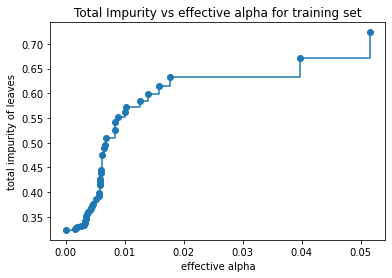

In [150]:
# fig, ax = plt.subplots()
# ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
# ax.set_xlabel("effective alpha")
# ax.set_ylabel("total impurity of leaves")
# ax.set_title("Total Impurity vs effective alpha for training set")

In [151]:
# clfs = []
# for ccp_alpha in ccp_alphas[ccp_alphas > 0]:
#     clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=10, min_samples_leaf=10, criterion='gini', class_weight='balanced')
#     clf.fit(train_df, train_outcome)
#     clfs.append(clf)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2764319133210833


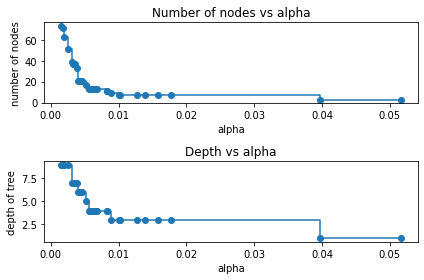

In [152]:
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]

# node_counts = [clf.tree_.node_count for clf in clfs]
# depth = [clf.tree_.max_depth for clf in clfs]
# fig, ax = plt.subplots(2, 1)
# ax[0].plot(ccp_alphas[ccp_alphas > 0], node_counts, marker='o', drawstyle="steps-post")
# ax[0].set_xlabel("alpha")
# ax[0].set_ylabel("number of nodes")
# ax[0].set_title("Number of nodes vs alpha")
# ax[1].plot(ccp_alphas[ccp_alphas > 0], depth, marker='o', drawstyle="steps-post")
# ax[1].set_xlabel("alpha")
# ax[1].set_ylabel("depth of tree")
# ax[1].set_title("Depth vs alpha")
# fig.tight_layout()

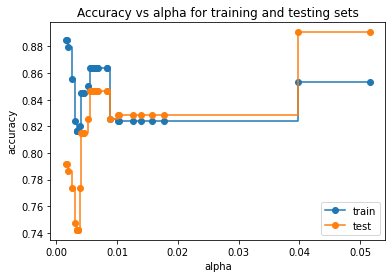

In [153]:
# train_scores = [clf.score(train_df, train_outcome) for clf in clfs]
# test_scores = [clf.score(test_df, test_outcome) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas[ccp_alphas > 0], train_scores, marker='o', label="train",
#         drawstyle="steps-post")
# ax.plot(ccp_alphas[ccp_alphas > 0], test_scores, marker='o', label="test",
#         drawstyle="steps-post")
# ax.legend()
# plt.show()

In [122]:
!pip install graphviz
!pip install pydotplus

In [154]:
sepsis_df.columns.drop(['admissionid', 'afib'])

Index(['urgency', 'is_sepsis_surgical', 'sofa_respiration_score',
       'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_cns_score', 'sofa_renal_score',
       'sofa_total_score', 'erythromycin', 'antiarrythmics', 'magnesium',
       'lowest_24hr_mean_abp', 'highest_24hr_mean_abp',
       'lowest_24hr_heart_rate', 'highest_24hr_heart_rate', 'lowest_24hr_ph',
       'highest_24hr_ph', 'lowest_24hr_oxygen_saturation',
       'highest_24hr_oxygen_saturation', 'lowest_24hr_na', 'highest_24hr_na',
       'bmi_max', 'admissionyear_2010s', 'female', 'agegroup_59-',
       'agegroup_60-69', 'agegroup_70-79', 'agegroup_80+', 'lowest_24hr_k',
       'highest_24hr_k'],
      dtype='object')

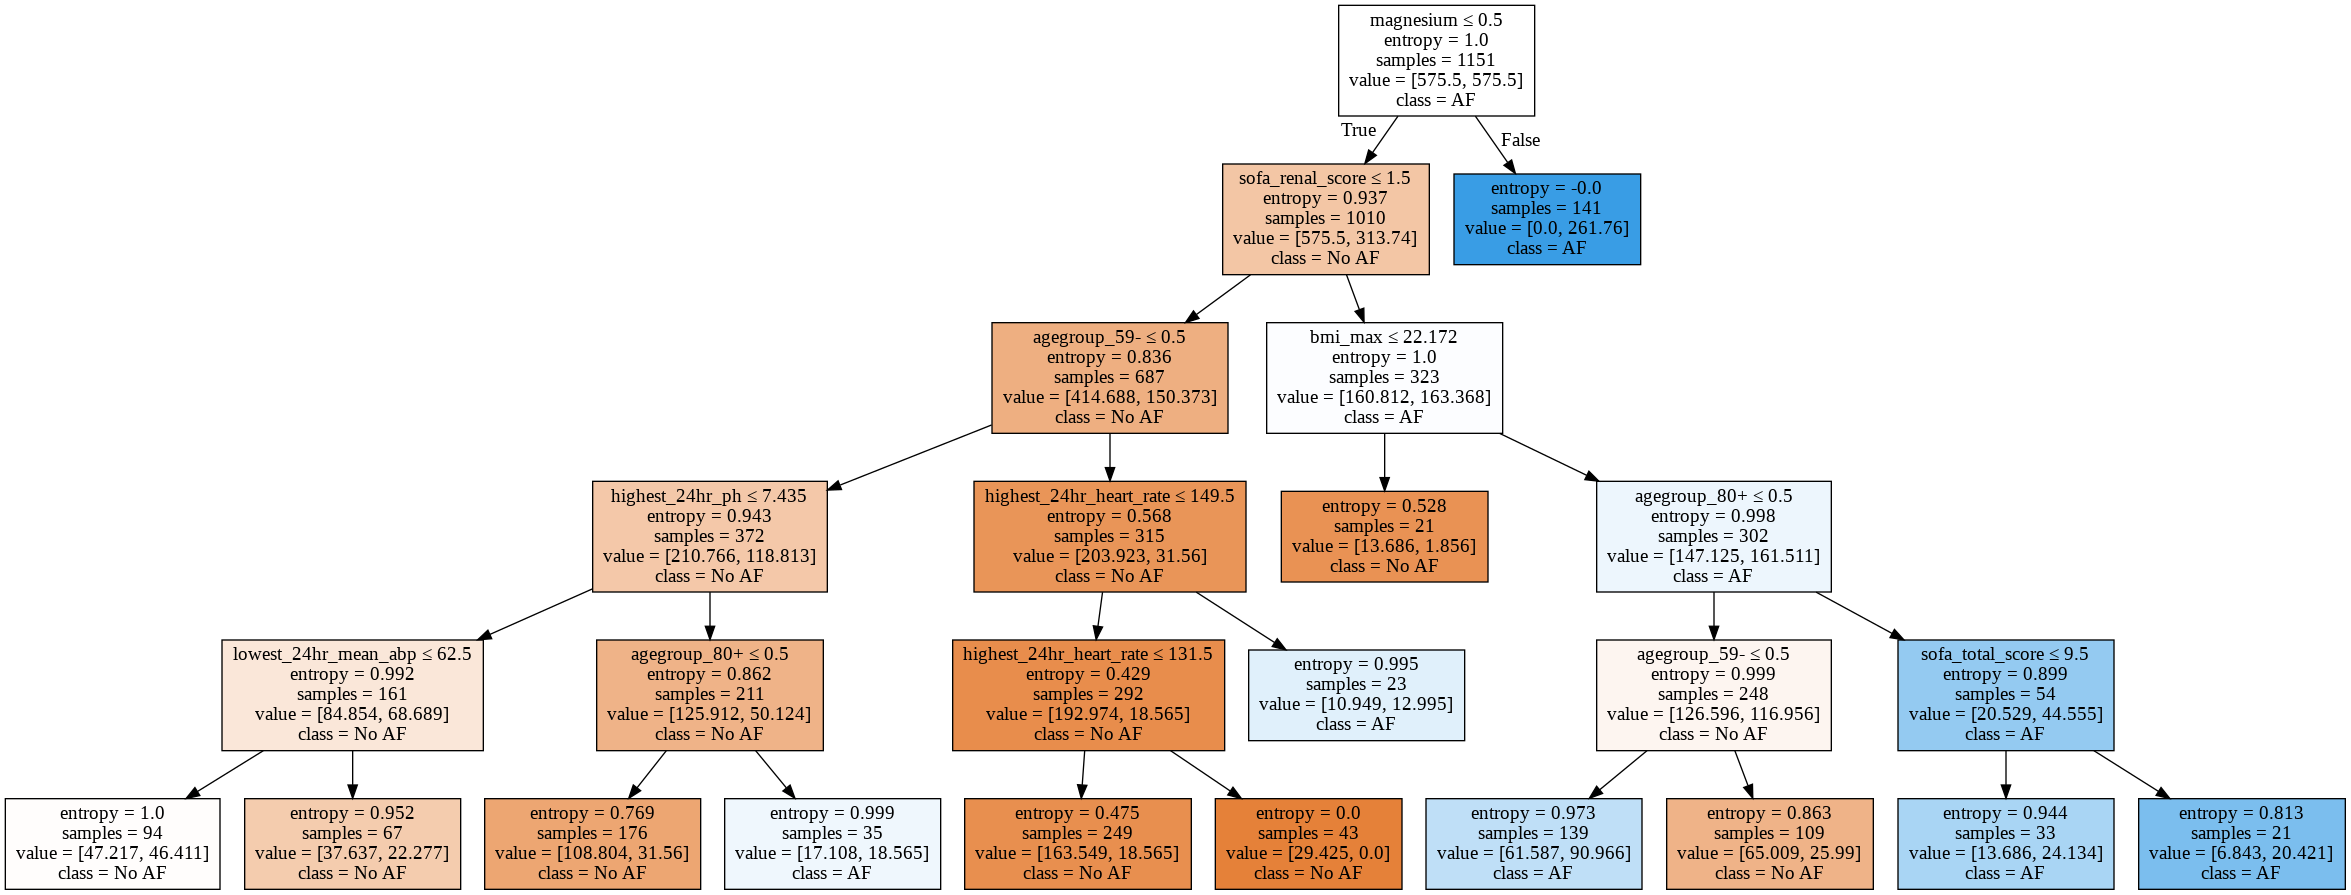

In [169]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

clf = tree.DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=20, \
                                  max_features='sqrt', criterion='entropy', class_weight='balanced')
clf.fit(train_df, train_outcome)
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=False,
                special_characters=True, 
                feature_names = sepsis_df.columns.drop(['admissionid', 'afib']), 
                class_names=['No AF','AF'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [167]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_leaf=20, \
                              max_features='sqrt', criterion='entropy', class_weight='balanced')
clf.fit(train_df, train_outcome)

print(clf.score(test_df, test_outcome))

# plt.figure()
# plt.plot([])

0.8541666666666666


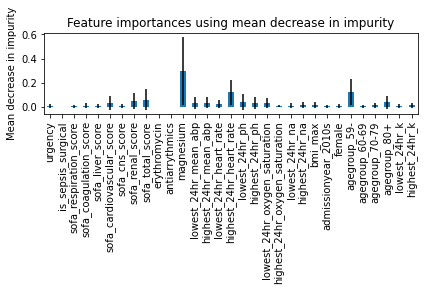

In [168]:
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

feature_names = train_df.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**CABG/valve surgery**

In [242]:
cardiosurg_df = model_df.loc[model_df['is_cardiosurg'] == 1, :].drop(columns = ['is_cardiosurg', 'is_sepsis', 'is_sepsis_surgical'])
cardiosurg_df.columns

cardiosurg_df = cardiosurg_df.loc[cardiosurg_df.drop(columns = ['afib_time']).isna().sum(axis = 1) == 0, :]
# sepsis_df['agegroup'] = sepsis_df['agegroup'].cat.rename_categories([])
# s.cat.rename_categories([1, 2, 3])
# sepsis_df.shape

In [179]:
train_df, test_df, train_outcome, test_outcome = train_test_split(cardiosurg_df.drop(columns = ['admissionid', 'afib', 'afib_time']), cardiosurg_df['afib'], random_state=0)

In [180]:
train_df.shape, test_df.shape, train_outcome.shape, test_outcome.shape

((3216, 31), (1072, 31), (3216,), (1072,))

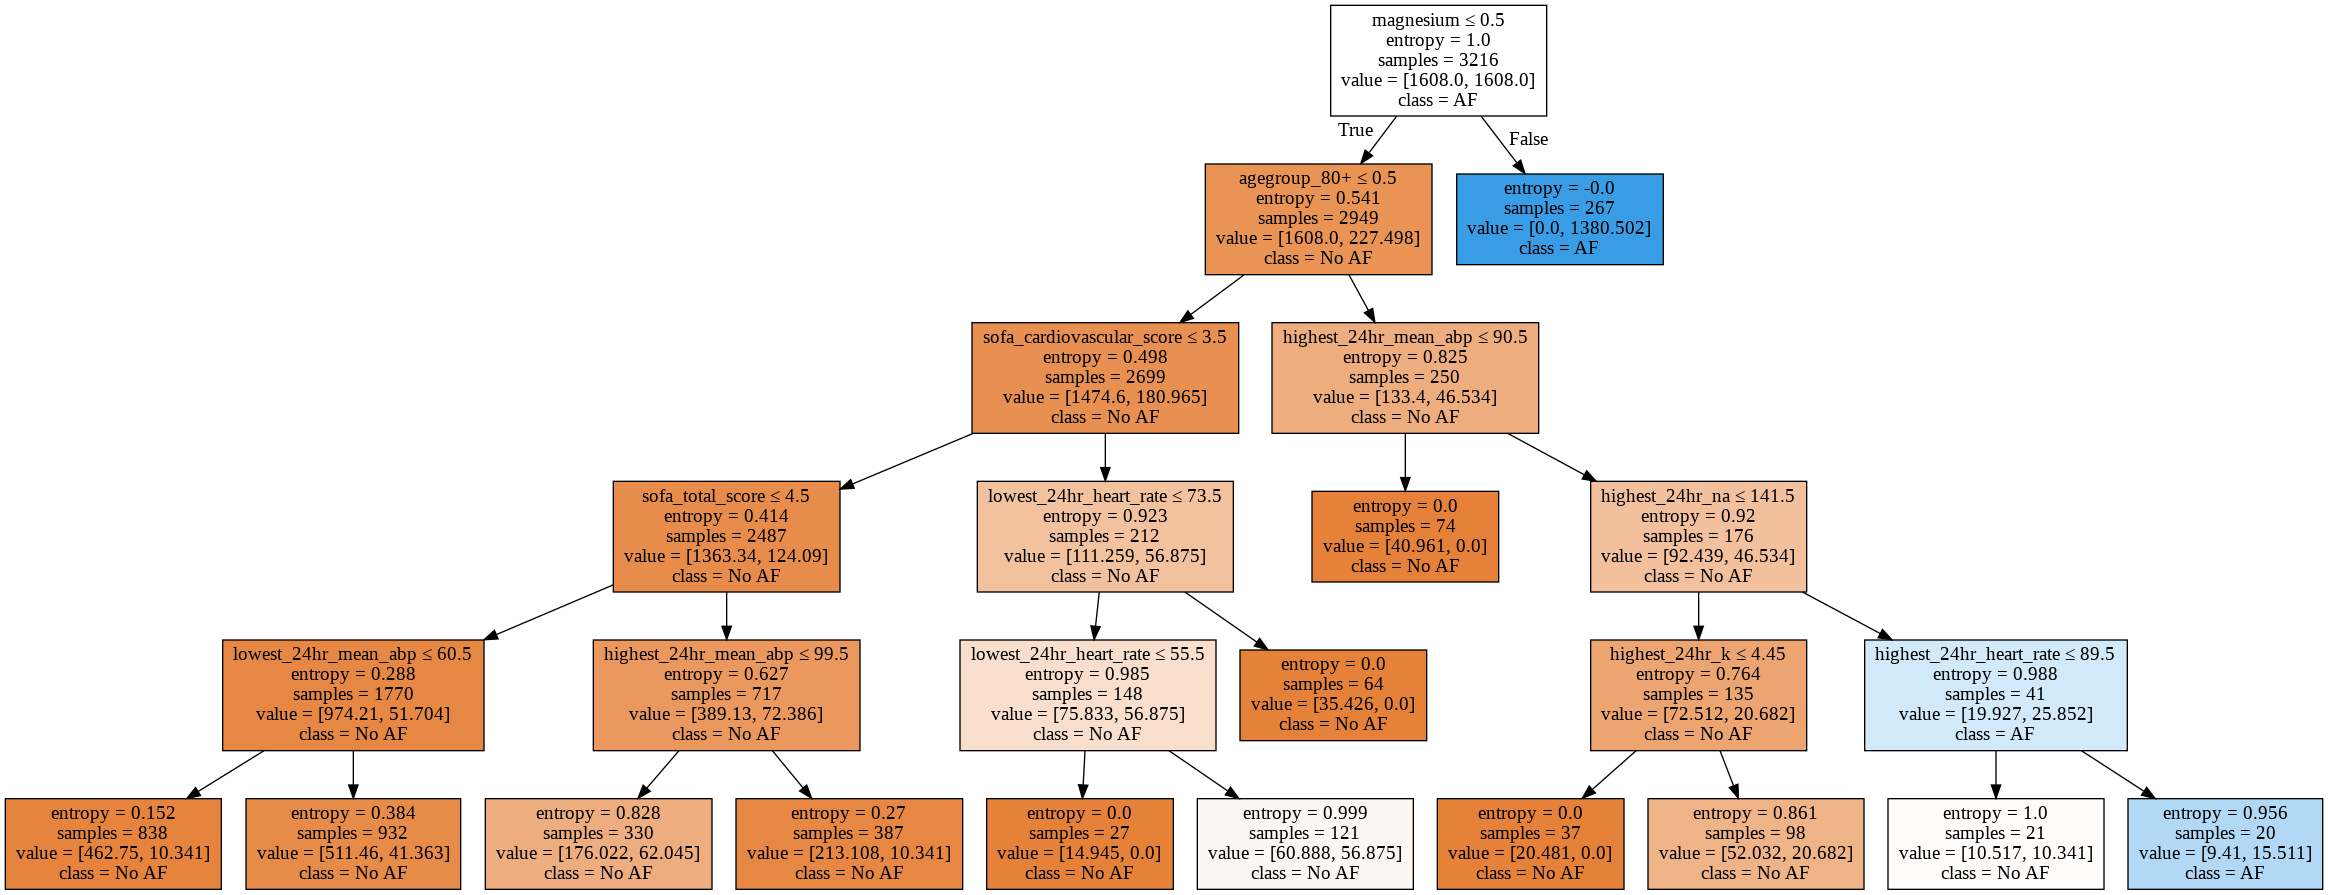

In [181]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

clf = tree.DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=20, \
                                  max_features='sqrt', criterion='entropy', class_weight='balanced')
clf.fit(train_df, train_outcome)
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=False,
                special_characters=True, 
                feature_names = sepsis_df.columns.drop(['admissionid', 'afib']), 
                class_names=['No AF','AF'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [182]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_leaf=20, \
                              max_features='sqrt', criterion='entropy', class_weight='balanced')
clf.fit(train_df, train_outcome)

print(clf.score(test_df, test_outcome))

# plt.figure()
# plt.plot([])

0.980410447761194


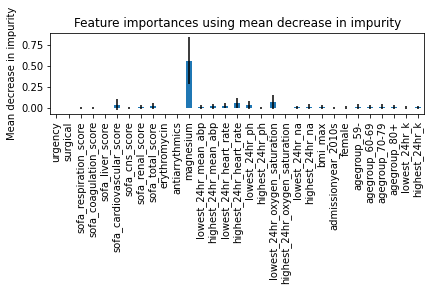

In [183]:
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

feature_names = train_df.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#Cox model

In [193]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

     |████████████████████████████████| 1.6MB 28.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Using cached scikit-survival-0.15.0.post0.tar.gz (2.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 32.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 51.8 MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061805 sha256=966d3a81d0e7dbaed2e67e7c209d57f91d21fceed0a37a40df6655d0b6af51c3
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


**Sepsis**

In [226]:
sepsis_df.loc[:, sepsis_df.dtypes == 'bool'] = sepsis_df.loc[:, sepsis_df.dtypes == 'bool'].astype(int)
train_df, test_df, train_outcome, test_outcome = \
  train_test_split(sepsis_df.drop(columns = ['admissionid', 'afib', 'afib_time']), sepsis_df[['afib', 'afib_time']], random_state=0)

## Right censor where we don't observe event within 5 days
train_outcome['afib'] = train_outcome['afib'].astype(bool)
test_outcome['afib'] = train_outcome['afib'].astype(bool)
train_outcome.loc[train_outcome['afib_time'].isna(), 'afib_time'] = 5*24*60 + 0.01
test_outcome.loc[test_outcome['afib_time'].isna(), 'afib_time'] = 5*24*60 + 0.01

train_outcome = train_outcome.to_records(index=False)
test_outcome = test_outcome.to_records(index=False)

Text(0.5, 0, 'time $t$ (minutes)')

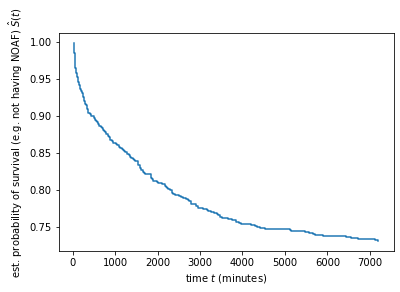

In [227]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(train_outcome['afib'], train_outcome['afib_time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival (e.g. not having NOAF) $\hat{S}(t)$")
plt.xlabel("time $t$ (minutes)")

In [239]:
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis(alpha = 0.01)
estimator.fit(train_df, train_outcome)

# estimator.coef_

pd.Series(estimator.coef_, index=train_df.columns)

urgency                          -0.137435
is_sepsis_surgical               -0.250618
sofa_respiration_score           -0.050340
sofa_coagulation_score           -0.005074
sofa_liver_score                  0.066246
sofa_cardiovascular_score         0.007307
sofa_cns_score                   -0.044521
sofa_renal_score                  0.081895
sofa_total_score                  0.055512
erythromycin                      0.377787
antiarrythmics                    0.557903
magnesium                         1.856801
lowest_24hr_mean_abp             -0.005071
highest_24hr_mean_abp            -0.008972
lowest_24hr_heart_rate           -0.009177
highest_24hr_heart_rate           0.023777
lowest_24hr_ph                    0.521082
highest_24hr_ph                  -0.003567
lowest_24hr_oxygen_saturation     0.167306
highest_24hr_oxygen_saturation    4.288211
lowest_24hr_na                   -0.006206
highest_24hr_na                   0.012205
bmi_max                           0.014535
admissionye

**CABG/valve surgery**

In [243]:
cardiosurg_df.loc[:, cardiosurg_df.dtypes == 'bool'] = cardiosurg_df.loc[:, cardiosurg_df.dtypes == 'bool'].astype(int)
train_df, test_df, train_outcome, test_outcome = \
  train_test_split(cardiosurg_df.drop(columns = ['admissionid', 'afib', 'afib_time']), cardiosurg_df[['afib', 'afib_time']], random_state=0)

## Right censor where we don't observe event within 5 days
train_outcome['afib'] = train_outcome['afib'].astype(bool)
test_outcome['afib'] = train_outcome['afib'].astype(bool)
train_outcome.loc[train_outcome['afib_time'].isna(), 'afib_time'] = 5*24*60 + 0.01
test_outcome.loc[test_outcome['afib_time'].isna(), 'afib_time'] = 5*24*60 + 0.01

train_outcome = train_outcome.to_records(index=False)
test_outcome = test_outcome.to_records(index=False)

Text(0.5, 0, 'time $t$ (minutes)')

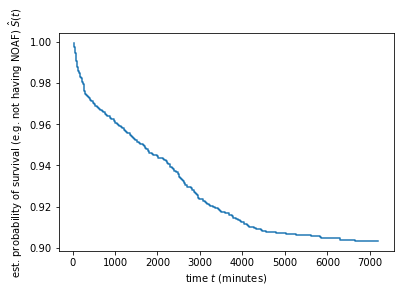

In [244]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(train_outcome['afib'], train_outcome['afib_time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival (e.g. not having NOAF) $\hat{S}(t)$")
plt.xlabel("time $t$ (minutes)")

In [245]:
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis(alpha = 0.01)
estimator.fit(train_df, train_outcome)

# estimator.coef_

pd.Series(estimator.coef_, index=train_df.columns)

urgency                           0.205494
surgical                          0.000000
sofa_respiration_score            0.025047
sofa_coagulation_score            0.125502
sofa_liver_score                  0.043902
sofa_cardiovascular_score        -0.011857
sofa_cns_score                   -0.006143
sofa_renal_score                 -0.210059
sofa_total_score                 -0.033608
erythromycin                     -0.136311
antiarrythmics                   -0.100556
magnesium                         5.420683
lowest_24hr_mean_abp             -0.002297
highest_24hr_mean_abp            -0.000324
lowest_24hr_heart_rate           -0.016716
highest_24hr_heart_rate           0.024878
lowest_24hr_ph                    0.790686
highest_24hr_ph                  -2.319932
lowest_24hr_oxygen_saturation    -0.039448
highest_24hr_oxygen_saturation   -2.188734
lowest_24hr_na                   -0.016478
highest_24hr_na                   0.021273
bmi_max                           0.033783
admissionye